Potting Data Analysis
=====================
The data in the Potting log files has data on the following parts
  - HDI wirebond pad groups
  - ROC wirebond pad groups
  - Address Pads on HDI
  - TBM wirebond pads on HDI side
  - TBM wirebond pads on TBM side
  - High-Voltage Pad on HDI
  - High-Voltage Pad on sensor

The data consists of 3-D measurements. Each measurement is spread over 3 rows. with the format

    x1
    y1
    z1
    x2
    y2
    z2
    ...
    ...

In the first line of data for each module there is a time stamp which indicates when the data taking was started and which mode was used ("HDIV3 + module" means real parts mode).     

The HDI has 16 pads groups (each group has 35 pads). Since the sylgard line must be delivered between two points
(start-stop) the first 6 numbers correspond to the first pads group start position and stop position
_____________________________________________________________________________
    241.926502      25/1/2016-18:52:49HDIV3 + module  #   |       | pad1-U1-x         
    213.485689                                        #   | start | pad1-U1-y         
    61.871853                                         #   |       | pad1-U1-z         
                                                      #   |       -
    241.942338                                        #   |       | pad35-U1-x        
    219.910052                                        #   |  stop | pad35-U1-y        
    61.874242                                         #   |       | pad35-U1-x        
_____________________________________________________________________________

The breakdown of numbers to parts is therefore

  - 96 lines(32 positions) for the 16 HDI pads groups. 
  - 12 lines(4 positions) for the address pads
  - 24 lines(8 positions) for the HDI-TBM pads (pads where the TBM is wired to the HDI)
  - 12 lines(4 positions) for the TBM pads
  - 3 lines(1 position) for the HV in the HDI side
  - 96 lines(32 positions) for the 16 ROC pads groups. 
  - 3 lines(1 position) for the HV in the sensor side

In [1]:
#setup matplotlib to have live plots in notebook and load datafile into memory
import matplotlib.pyplot as plt
%matplotlib notebook
with open('pottingData.lvm', 'r') as f:
    lines = f.readlines() 

To parse the data file, just read 3 lines at a time to build individual vectors. Each module's data has a known number of measurements(82) so the list of vectors can be split into groups and assembled into `Module` objects.

In [2]:
from collections import namedtuple
from statistics import mean,stdev
Vector = namedtuple('Vector',['x','y','z'])
def parse_vectors(lines):
    vecs = []
    lines_iter = iter(lines)
    def tokenize(l):
        l = l.split('#')[-1]
        return [t for t in l.split() if t]
    while lines_iter:
        try:
            x = float(tokenize(next(lines_iter))[0])
            y = float(tokenize(next(lines_iter))[0])
            z = float(tokenize(next(lines_iter))[0])
            vecs.append(Vector(x,y,z))
        except IndexError:
            pass
        except StopIteration:
            break
    return vecs
        
vecs = parse_vectors(lines)

class Module:
    n = 82
    def __init__(self, vecs):
        self.hdi_bond_pads = vecs[0:32]  # 32 measurements
        self.address_pads = vecs[32:36]  # 4 measurements
        self.tbm_on_hdi = vecs[36:44]    # 8 measurements
        self.tbm_on_tbm = vecs[44:48]    # 4 measurements
        self.hdi_hv_pad = vecs[48]
        self.roc_bond_pads = vecs[49:81] # 32 measurements
        self.roc_hv_pad = vecs[81]

def parse_modules(vectors):
    n = Module.n
    num_modules = len(vectors)//n
    return [Module(vectors[i*n:(i+1)*n]) for i in range(num_modules)]
    

modules = parse_modules(vecs)

Now that the potting data has been successfully loaded into an appropriate data structure, some plots can be done.

First, let's look at the location of the potting positions on the TBM, both TBM and HDI side

<IPython.core.display.Javascript object>


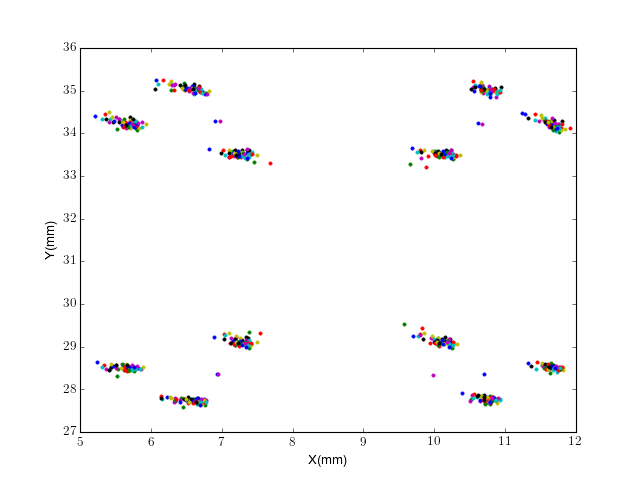

Mean TBM_TBM X-Trace Length 2.8467542807017545 +- 0.19208705087355818 mm
Mean TBM_TBM Y-Trace Length 4.436071807017543 +- 0.30329804644801633 mm
Mean TBM_HDI X-Trace Length 4.211082517543861 +- 0.1521287134757683 mm
Mean TBM_HDI Y-Trace Length 5.719003640350876 +- 0.08557911872307672 mm


In [3]:
tbm_horiz = []
tbm_verti = []
hdi_horiz = []
hdi_verti = []
plt.figure()
for module in modules:
    tbm_horiz.append(module.tbm_on_tbm[1][0]-module.tbm_on_tbm[0][0])
    tbm_horiz.append(module.tbm_on_tbm[2][0]-module.tbm_on_tbm[3][0])
    tbm_verti.append(module.tbm_on_tbm[3][1]-module.tbm_on_tbm[0][1])
    tbm_verti.append(module.tbm_on_tbm[2][1]-module.tbm_on_tbm[1][1])
    
    hdi_horiz.append(module.tbm_on_hdi[1][0]-module.tbm_on_hdi[0][0])
    hdi_horiz.append(module.tbm_on_hdi[4][0]-module.tbm_on_hdi[5][0])
    hdi_verti.append(module.tbm_on_hdi[3][1]-module.tbm_on_hdi[2][1])
    hdi_verti.append(module.tbm_on_hdi[6][1]-module.tbm_on_hdi[7][1])
    
    xs = []
    ys = []
    offset_x, offset_y,_ = module.hdi_bond_pads[0]
    for i,point in enumerate(module.tbm_on_hdi):
        xs.append(point[0]-offset_x)
        ys.append(point[1]-offset_y)
    for i,point in enumerate(module.tbm_on_tbm):
        xs.append(point[0]-offset_x)
        ys.append(point[1]-offset_y)
    plt.plot(xs,ys,'.')
plt.xlabel("X(mm)")
plt.ylabel("Y(mm)")
print("Mean TBM_TBM X-Trace Length",mean(tbm_horiz),"+-",stdev(tbm_horiz),"mm")
print("Mean TBM_TBM Y-Trace Length",mean(tbm_verti),"+-",stdev(tbm_verti),"mm")
print("Mean TBM_HDI X-Trace Length",mean(hdi_horiz),"+-",stdev(hdi_horiz),"mm")
print("Mean TBM_HDI Y-Trace Length",mean(hdi_verti),"+-",stdev(hdi_verti),"mm")

So now we know what the average and standard deviation of the trace lengths on the TBM are. good.
___________________________________________________________________________

Now let's examine how flat the Modules are overall by looking at the points for the HDI and BBM bond pads in the YZ plane. 

<IPython.core.display.Javascript object>


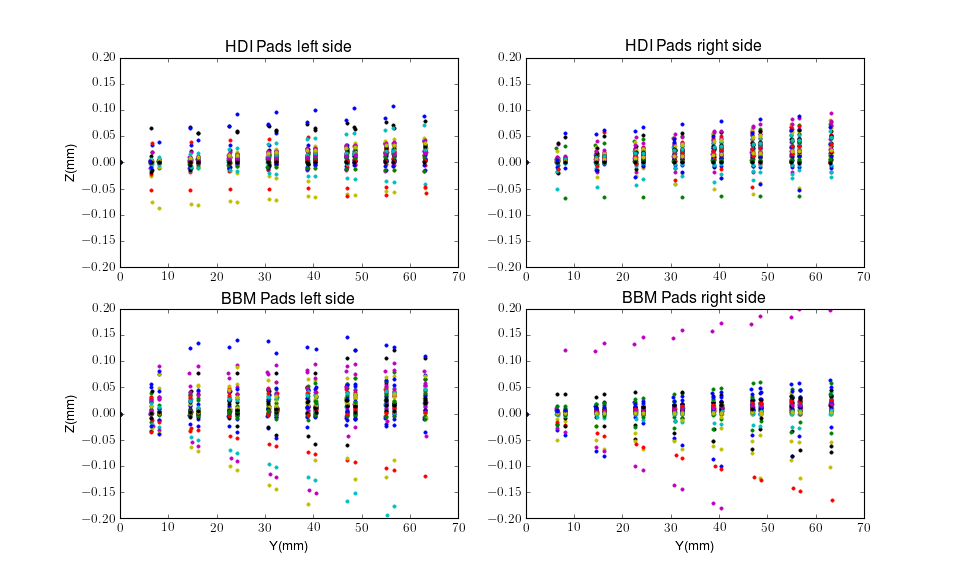

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
for i, module in enumerate(modules):
    ys = []
    zs = []
    _, offset_y, offset_z = module.hdi_bond_pads[0]
    for bond_pad in module.hdi_bond_pads[:16]:
        ys.append(bond_pad[1]-offset_y)
        zs.append(bond_pad[2]-offset_z)
    axes[0][0].plot(ys,zs,'.', label=str(i))
    
    ys.clear()
    zs.clear()
    _, offset_y, offset_z = module.hdi_bond_pads[16]
    for bond_pad in module.hdi_bond_pads[16:]:
        ys.append(bond_pad[1]-offset_y)
        zs.append(bond_pad[2]-offset_z)
    axes[0][1].plot(ys,zs,'.', label=str(i))
    
    ys.clear()
    zs.clear()
    _, offset_y, offset_z = module.roc_bond_pads[0]
    for bond_pad in module.roc_bond_pads[:16]:
        ys.append(bond_pad[1]-offset_y)
        zs.append(bond_pad[2]-offset_z)
    axes[1][0].plot(ys,zs,'.', label=str(i))

    ys.clear()
    zs.clear()
    _, offset_y, offset_z = module.roc_bond_pads[16]
    for bond_pad in module.roc_bond_pads[16:]:
        ys.append(bond_pad[1]-offset_y)
        zs.append(bond_pad[2]-offset_z)
    axes[1][1].plot(ys,zs,'.', label=str(i))


axes[0][0].set_ylabel('Z(mm)')
axes[1][0].set_ylabel('Z(mm)')
axes[1][0].set_xlabel('Y(mm)')
axes[1][1].set_xlabel('Y(mm)')

axes[0][0].set_ylim((-.20,.20))
axes[0][0].set_title("HDI Pads left side")
axes[0][1].set_ylim((-.20,.20))
axes[0][1].set_title("HDI Pads right side")
axes[1][0].set_ylim((-.20,.20))
axes[1][0].set_title("BBM Pads left side")
axes[1][1].set_ylim((-.20,.20))
axes[1][1].set_title("BBM Pads right side")
        